Run the following helper functions

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import ks_2samp
import itertools
import networkx as nx
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.patches as mpatches
from scipy.spatial.distance import cdist


# Loads the dataset from a csv file
def load_data(file_path, columns_to_numeric):
    df = pd.read_csv(file_path, engine='python')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')
    return df

# Cleans the dataset by removing rows with NaN values
def clean_data(df):
    return df.dropna()

# Plots a correlation heatmap for the specified columns
def plot_correlation_heatmap(df, columns):
    corr_matrix = df[columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                linewidths=0.5, square=True, cbar_kws={'label': 'Correlation Coefficient (R)'})
    plt.title("Correlation Matrix with R-values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Checks for missing values in the dataset and prints the count of missing values per column
def analyze_missing_values(df):
    print("Missing values per column:\n")
    missing_counts = df.isnull().sum()
    for col, count in missing_counts.items():
        if count > 0:
            print(f"{col}: {count}")

# Prints rows with missing values 
def print_missing_rows(df):
    for col in df.columns:
        missing_rows = df[df[col].isna()]
        if not missing_rows.empty:           
            print(f"Rows with missing values in column '{col}':\n")
            print(missing_rows)

# Plots density distributions for each numeric column in the dataset
def plot_density_per_column(df):
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(data=df, x=col, fill=True)
        plt.title(f"Density Plot: {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.tight_layout()
        plt.show()

# Describes the distribution and frequency of labels in the dataset
def describe_label_distribution(df, label_col='Label'):
    labels = df[label_col]
    label_counts = labels.value_counts(normalize=True) * 100
    print("Label Frequencies (%):")
    for label, pct in label_counts.items():
        print(f"- {label}: {pct:.2f}%")
    mode_label = labels.mode().iloc[0]
    mode_count = (labels == mode_label).sum()
    mode_pct = label_counts[mode_label]
    print(f"\nMost frequent label: {mode_label} ({mode_count} occurrences, {mode_pct:.2f}%)")

# Describes the variables in the dataset, including their scales and statistics
def describe_variables(df, variable_info):
    for col, scale in variable_info.items():
        print(f"\nVariable: {col}")
        print(f"Scale: {scale.capitalize()}")
        col_data = df[col].dropna()
        if not col_data.empty:
            mode = col_data.mode().iloc[0]
            mode_count = (col_data == mode).sum()
            mode_pct = (mode_count / len(col_data)) * 100
            print(f"Mode: {mode} ({mode_count} occurrences, {mode_pct:.2f}%)")
        else:
            print("Mode: N/A")

        if scale in ['ordinal', 'interval', 'ratio']:
            print(f"Median: {col_data.median()}")
        if scale in ['interval', 'ratio']:
            print(f"Mean: {col_data.mean()}")
            print(f"Standard Deviation: {col_data.std()}")

# Removes duplicate rows from the dataset
def remove_duplicate_rows(df):
    df.drop_duplicates(inplace=True)

def flag_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_col_name = f"{column}_Outlier"
    df[outlier_col_name] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df, lower_bound, upper_bound

def apply_outlier_flagging(df, columns):
    for col in columns:
        df, lb, ub = flag_outliers_iqr(df, col)
        outlier_col = f"{col}_Outlier"
        num_outliers = df[outlier_col].sum()
        total = len(df)
        percentage = (num_outliers / total) * 100

        print(f"Outlier threshold for {col}:")
        print(f" - Lower bound: {lb}")
        print(f" - Upper bound: {ub}")
        print(f" - Number of outliers in '{col}': {num_outliers} ({percentage:.2f}%)\n")
    return df

def analyze_outlier_overlap(df, outlier_columns):
    print("\nOutlier Overlap Matrix (% of shared outliers):\n")
    for col1 in outlier_columns:
        for col2 in outlier_columns:
            if col1 == col2:
                continue
            # Rows where both columns are marked as outliers
            both_outliers = df[df[col1] & df[col2]]
            count = len(both_outliers)

            # % of outliers in col1 that are also outliers in col2
            col1_outliers = df[df[col1]]
            percent = (count / len(col1_outliers) * 100) if len(col1_outliers) else 0
            if percent >= 50:
                print(f"{col1} ∩ {col2}: {count} rows ({percent:.2f}%)")


def pca_spss_style(df, columns, n_components=None):
    """
    Perform PCA and print SPSS-style tables: variance explained and component matrix.

    Parameters:
        df (pd.DataFrame): Cleaned dataframe.
        columns (list): Numeric columns to include in PCA.
        n_components (int or None): Number of components (default = all).
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[columns])

    # Fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    components = pca.transform(X_scaled)

    # Explained Variance Table
    eigenvalues = pca.explained_variance_
    variance_ratios = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratios)

    variance_df = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
        'Eigenvalue': eigenvalues,
        '% of Variance': variance_ratios * 100,
        'Cumulative %': cumulative_variance * 100
    })

    print("\n--- Total Variance ---")
    print(variance_df.round(2).to_string(index=False))

    # Component Loadings (Component Matrix)
    loadings = pd.DataFrame(pca.components_.T,
                            columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                            index=columns)

    print("\n--- Component Matrix --")
    print(loadings.round(2))

    return variance_df, loadings, pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

def run_kmeans_pca_analysis(pca_data, max_k=10):
    inertias = []
    silhouettes = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(pca_data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(pca_data, labels))

    # Plot elbow curve
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouettes, marker='o')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

    # Return both lists to help decide
    return inertias, silhouettes

def detect_anomalies_isolation_forest(df, features, contamination=0.01):

    clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    X = df[features].dropna()
    clf.fit(X)
    
    anomaly_labels = clf.predict(X)
    anomaly_scores = clf.decision_function(X)
    
    df.loc[X.index, 'AnomalyIF'] = (anomaly_labels == -1).astype(int)
    df.loc[X.index, 'Anomaly_ScoreIF'] = -anomaly_scores  # Higher = more anomalous

    return df


def plot_3d_clusters_sampled(pca_df, labels, sample_size=5000):
    if not isinstance(labels, pd.Series):
        labels = pd.Series(labels, index=pca_df.index)

    # Create a new DataFrame combining PCA and labels
    combined_df = pca_df.copy()
    combined_df["Cluster"] = labels

    # Stratified sampling: keep at least some of each cluster
    sampled_df = combined_df.groupby("Cluster", group_keys=False).apply(
        lambda x: x.sample(min(len(x), sample_size // len(combined_df["Cluster"].unique())), random_state=42)
    )

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        sampled_df['PC1'],
        sampled_df['PC2'],
        sampled_df['PC3'],
        c=sampled_df['Cluster'],
        cmap='tab10',
        s=10,
        alpha=0.7
    )

    ax.set_title("3D PCA Cluster Visualization (sampled, stratified)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.tight_layout()
    plt.show()


def run_kmeans_clustering(pca_data, n_clusters):
    """
    Runs KMeans on PCA-transformed data with a specified number of clusters.

    Parameters:
        pca_data (pd.DataFrame or np.ndarray): PCA-reduced feature data
        n_clusters (int): Number of clusters to form

    Returns:
        labels (np.ndarray): Cluster labels for each point
        kmeans (KMeans): The fitted KMeans model
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    return labels, kmeans


def plot_elbow_method(data, max_k=10):
    inertias = []
    ks = range(1, max_k + 1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (within-cluster sum of squares)')
    plt.xticks(ks)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def interpret_clusters(df, feature_columns):
    summary = df.groupby('Cluster')[feature_columns].agg(['mean', 'std']).round(2)
    return summary


def plot_normalized_cluster_mean_heatmap(df, feature_columns, cluster_col='Cluster'):
    """
    Plots a heatmap of normalized mean feature values for each cluster.
    Values are normalized per feature using min-max scaling for comparability.
    """
    cluster_means = df.groupby(cluster_col)[feature_columns].mean()
    
    # Min-max normalization (column-wise)
    cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means_normalized, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title("Normalized Heatmap of Cluster Mean Feature Values")
    plt.xlabel("Feature")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()


def temporal_analysis(file_path, timestamp_col='Timestamp', cluster_col='Cluster'):
    # Load data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Parse timestamp
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format="%d/%m/%Y %I:%M:%S %p", errors='coerce')
    df = df.dropna(subset=[timestamp_col, cluster_col])  # Drop bad timestamps or missing clusters

    # Extract temporal features
    df['Hour'] = df[timestamp_col].dt.hour
    df['DayOfWeek'] = df[timestamp_col].dt.day_name()

    # Plot hourly distribution for each cluster
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='Hour', hue=cluster_col, palette='tab10')
    plt.title('Cluster Activity by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    # Plot day of week distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='DayOfWeek', hue=cluster_col, order=[
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    plt.title('Cluster Activity by Day of Week')
    plt.xlabel('Day')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    hourly_summary = df.groupby([cluster_col, 'Hour']).size().unstack(fill_value=0)
    daily_summary = df.groupby([cluster_col, 'DayOfWeek']).size().unstack(fill_value=0)
    hourly_summary.to_csv("hourly_cluster_distribution.csv")
    daily_summary.to_csv("daily_cluster_distribution.csv")


def run_temporal_ks_tests(df, features, time_col='Hour', cluster_col='Cluster'):
    results = []

    time_groups = df[time_col].dropna().unique()
    for time_val in sorted(time_groups):
        df_time = df[df[time_col] == time_val]
        clusters = df_time[cluster_col].dropna().unique()
        cluster_pairs = list(itertools.combinations(clusters, 2))

        for feature in features:
            for c1, c2 in cluster_pairs:
                x = df_time[df_time[cluster_col] == c1][feature].dropna()
                y = df_time[df_time[cluster_col] == c2][feature].dropna()

                if len(x) > 0 and len(y) > 0:
                    stat, p = ks_2samp(x, y)
                    results.append({
                        'Time': time_val,
                        'Feature': feature,
                        'Cluster 1': c1,
                        'Cluster 2': c2,
                        'KS Statistic (D)': round(stat, 4),
                        'Raw p-value': p
                    })

    ks_df = pd.DataFrame(results)

    # Apply Bonferroni correction
    m = len(ks_df)
    ks_df['Bonferroni alpha'] = 0.05 / m
    ks_df['Adjusted Significant'] = ks_df['Raw p-value'] < ks_df['Bonferroni alpha']
    ks_df['Adjusted p-value'] = ks_df['Raw p-value'] * m
    ks_df['Adjusted p-value'] = ks_df['Adjusted p-value'].clip(upper=1.0)  # Ensure max 1.0

    return ks_df



def extract_ip_pair(flow_id):
    try:
        src_ip, dst_ip, *_ = flow_id.split('-')
        return src_ip, dst_ip
    except:
        return None, None

def build_info_flow_graph(df, flow_column='Flow ID'):
    # Step 1: Extract source and destination IPs
    df[['SrcIP', 'DstIP']] = df[flow_column].apply(lambda x: pd.Series(extract_ip_pair(x)))
    
    # Step 2: Create directed graph
    G = nx.DiGraph()
    
    # Step 3: Add edges for each flow
    for _, row in df.iterrows():
        if pd.notna(row['SrcIP']) and pd.notna(row['DstIP']):
            G.add_edge(row['SrcIP'], row['DstIP'])
    
    return G

def plot_info_flow_graph(G, max_nodes=100):

    if len(G.nodes) > max_nodes:
        print(f"Showing only {max_nodes}.")
        G = G.subgraph(list(G.nodes)[:max_nodes])

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.5, seed=42)  # layout with spacing

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Draw edges with arrows
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        arrows=True,
        arrowstyle='-|>',    \
        arrowsize=20,
        connectionstyle='arc3,rad=0.1'  \
    )

    plt.title("Directed Information Flow Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def summarize_anomalies_by_cluster(df, cluster_col='Cluster', anomaly_col='Anomaly'):
    """
    Returns a summary DataFrame with anomaly counts and percentages for each cluster.
    """
    anomalies = df[df[anomaly_col] == 1][cluster_col].value_counts().sort_index()
    normals = df[df[anomaly_col] == 0][cluster_col].value_counts().sort_index()

    summary_df = pd.DataFrame({
        'Anomalies': anomalies,
        'Normal': normals
    }).fillna(0)

    summary_df['Total'] = summary_df['Anomalies'] + summary_df['Normal']
    summary_df['Anomaly Rate (%)'] = 100 * summary_df['Anomalies'] / summary_df['Total']
    return summary_df

def plot_anomaly_rates(summary_df):
    """
    Plots anomaly rates per cluster from a summary DataFrame.
    """
    summary_df = summary_df.copy()

    # Only reset index if 'Cluster' is not already a column
    if 'Cluster' not in summary_df.columns:
        summary_df['Cluster'] = summary_df.index

    plt.figure(figsize=(8, 5))
    sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')
    plt.title("Anomaly Rate per Cluster")
    plt.ylabel("Anomaly Percentage")
    plt.xlabel("Cluster")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


def compare_anomaly_distributions(df, features, cluster_col='Cluster', anomaly_col='Anomaly'):
    """
    Plots KDE plots for each feature and cluster, comparing anomaly vs normal.
    """
    unique_clusters = sorted(df[cluster_col].dropna().unique())

    for cluster_id in unique_clusters:
        for feature in features:
            plt.figure(figsize=(8, 4))
            subset = df[df[cluster_col] == cluster_id]

            sns.kdeplot(subset[subset[anomaly_col] == 0][feature], label='Normal', fill=True)
            sns.kdeplot(subset[subset[anomaly_col] == 1][feature], label='Anomaly', fill=True)

            plt.title(f"{feature} Distribution in Cluster {cluster_id}")
            plt.xlabel(feature)
            plt.legend()
            plt.tight_layout()
            plt.show()


def geometric_median(X, eps=1e-5):
    y = np.mean(X, axis=0)
    while True:
        D = np.linalg.norm(X - y, axis=1)
        nonzeros = D != 0
        if not np.any(nonzeros):
            return y
        Dinv = 1 / D[nonzeros]
        W = Dinv / Dinv.sum()
        T = (X[nonzeros] * W[:, None]).sum(axis=0)
        if np.linalg.norm(y - T) < eps:
            return T
        y = T

def geometric_median_outliers(df, features, threshold_percentile=95):
    X = df[features].dropna().values
    gm = geometric_median(X)
    distances = np.linalg.norm(X - gm, axis=1)
    
    threshold = np.percentile(distances, threshold_percentile)
    
    outlier_mask = distances > threshold
    df.loc[df[features].dropna().index, 'GeoMed_Outlier'] = outlier_mask.astype(int)
    df.loc[df[features].dropna().index, 'GeoMed_Distance'] = distances
    return df

def plot_geomed_outliers_pca(pca_df, df, outlier_col='GeoMed_Outlier', title_suffix=""):

    # Merge PCA with outlier flags
    plot_df = pca_df[['PC1', 'PC2']].copy()
    plot_df[outlier_col] = df[outlier_col]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=plot_df,
        x='PC1',
        y='PC2',
        hue=plot_df[outlier_col].map({0: "Normal", 1: "Outlier"}),
        palette={"Normal": "blue", "Outlier": "red"},
        alpha=0.5,
        s=10
    )
    
    plt.title(f"Geometric Median Outliers in PCA Space {title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    legend_handles = [
        mpatches.Patch(color='blue', label='Normal'),
        mpatches.Patch(color='red', label='Outlier')
    ]
    plt.legend(handles=legend_handles, title="Status")
    plt.tight_layout()
    plt.show()


def _mad_flags(x, z_thresh=3.5):
    x = pd.to_numeric(x, errors='coerce')
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    mad_n = 1.4826 * mad if np.isfinite(mad) else np.nan   # normalized MAD
    if (not np.isfinite(mad_n)) or mad_n == 0:
        return pd.Series(False, index=x.index), med, mad_n
    z = np.abs(x - med) / mad_n
    return (z > z_thresh), med, mad_n


def detect_anomalies_oneclass_svm_on_pcs(
    df: pd.DataFrame,
    pc_scores_df: pd.DataFrame,
    nu: float = 0.02,
    train_n: int = 20000,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Fits RBF One-Class SVM on *existing PCA components* (PC1..PCk).
    Safe write-back using drop-then-join; no KeyError or overlap errors.
    """
    # --- 1) Grab PCA matrix ---
    pc_cols = [c for c in pc_scores_df.columns if c.upper().startswith("PC")]
    if not pc_cols:
        raise ValueError("pc_scores_df must have columns named like 'PC1','PC2', ...")
    Z = pc_scores_df[pc_cols].to_numpy()

    # --- 2) Subsample to fit (for speed on ~100k) ---
    rng = np.random.default_rng(random_state)
    fit_idx = rng.choice(Z.shape[0], size=min(train_n, Z.shape[0]), replace=False)

    # --- 3) Train + score ---
    oc = OneClassSVM(kernel="rbf", gamma="scale", nu=nu)
    oc.fit(Z[fit_idx])

    scores = -oc.decision_function(Z).ravel()        # higher = more anomalous
    flags  = (oc.predict(Z) == -1).astype(int)       # 1 = anomaly

    # --- 4) Build results indexed like pc_scores_df ---
    ocsvm_res = pd.DataFrame(
        {"OCSVM_Score": scores, "Anomaly_OCSVM": flags},
        index=pc_scores_df.index
    )

    # --- 5) Idempotent write-back: drop overlapping cols, then join ---
    overlap = [c for c in ocsvm_res.columns if c in df.columns]
    df_out = df.drop(columns=overlap, errors="ignore").join(ocsvm_res, how="left")

    return df_out

def plot_geomed_distance_histogram(df, distance_col='GeoMed_Distance', threshold_percentile=95):
    threshold = np.percentile(df[distance_col].dropna(), threshold_percentile)
    
    plt.figure(figsize=(8, 5))
    sns.histplot(df[distance_col], bins=100, kde=True)
    plt.axvline(threshold, color='red', linestyle='--', label=f'{threshold_percentile}th percentile')
    plt.title("Distribution of Distances from Geometric Median")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

Setup

In [130]:
file_path = "DarknetWorking.csv"
selected_columns = [
    'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Mean',
    'Bwd Packet Length Mean', 'Packet Length Std', 'Idle Mean'
]

variable_scales = {col: 'ratio' for col in selected_columns}

Load and clean

In [131]:
df = load_data(file_path, selected_columns)
analyze_missing_values(df)
print_missing_rows(df)
df = clean_data(df)

Missing values per column:

Flow Bytes/s: 49
Flow Packets/s: 49
Rows with missing values in column 'Flow Bytes/s':

                                           Flow ID               Timestamp  \
32903     173.194.40.103-10.152.152.11-443-52701-6  22/07/2015 01:55:40 PM   
33148          2.22.9.25-10.152.152.11-443-37492-6          9/7/2015 10:25   
33174         31.13.93.7-10.152.152.11-443-41051-6          9/7/2015 10:25   
33324      173.194.67.16-10.152.152.11-465-35807-6  13/07/2015 04:23:07 PM   
33597     173.194.207.16-10.152.152.11-465-33190-6  13/07/2015 01:32:16 PM   
35854      10.152.152.11-54.230.228.31-47339-443-6  27/07/2015 01:38:59 PM   
36427       46.228.164.20-10.152.152.11-80-44537-6  27/07/2015 01:36:39 PM   
36631      23.206.24.104-10.152.152.11-443-60982-6  27/07/2015 01:42:02 PM   
36641         10.152.152.11-31.13.64.1-45140-443-6  27/07/2015 01:18:32 PM   
36648    173.241.240.220-10.152.152.11-443-56194-6  27/07/2015 01:38:52 PM   
36760     10.152.152.10-10

Analysis and visualization

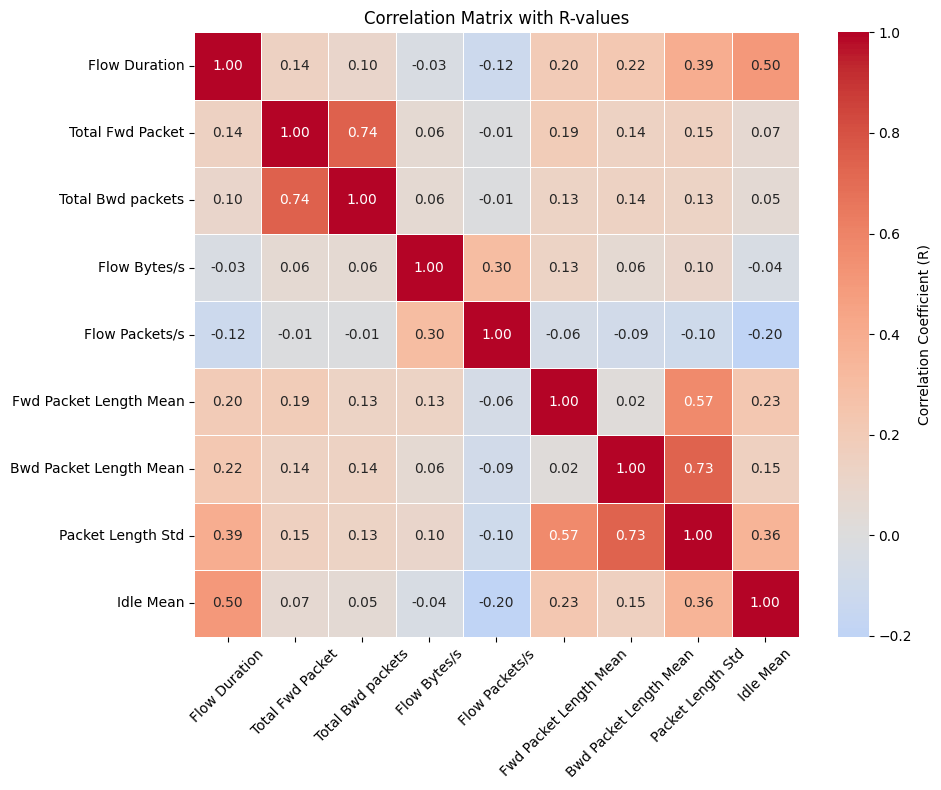

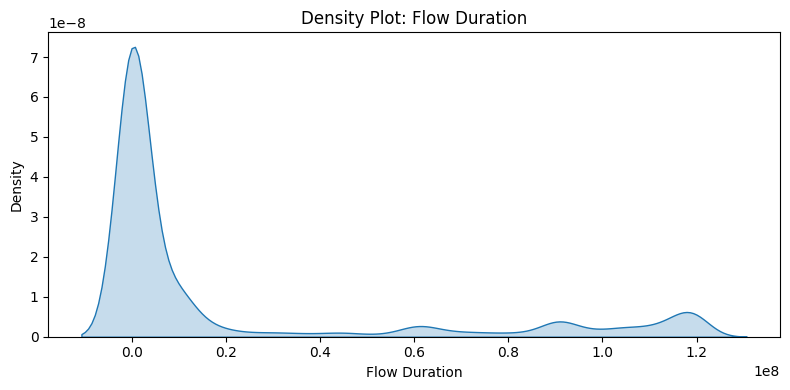

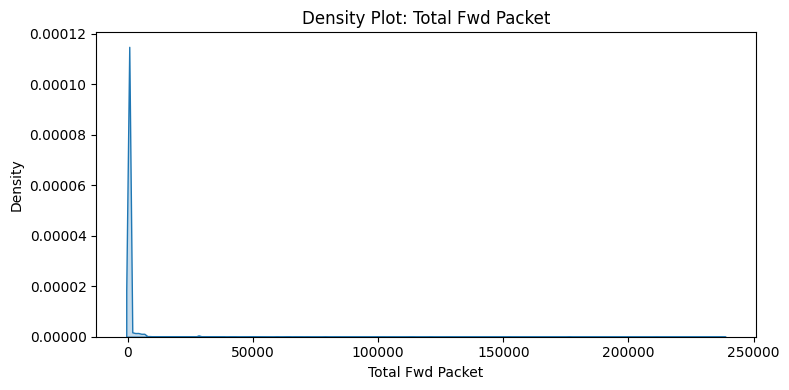

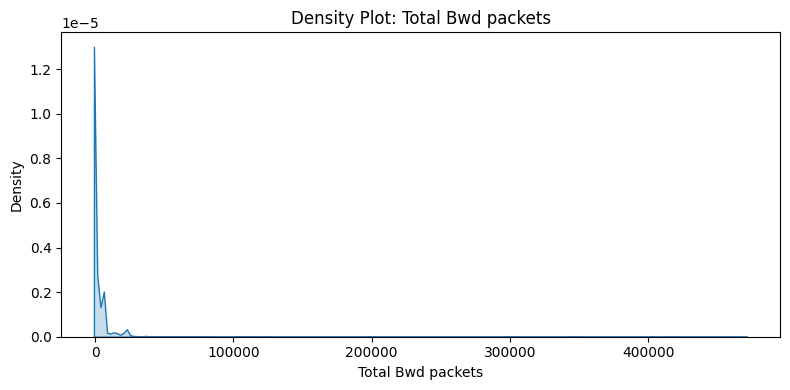

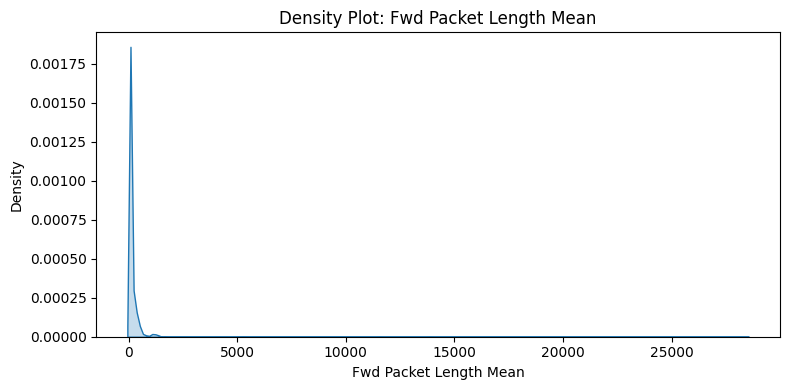

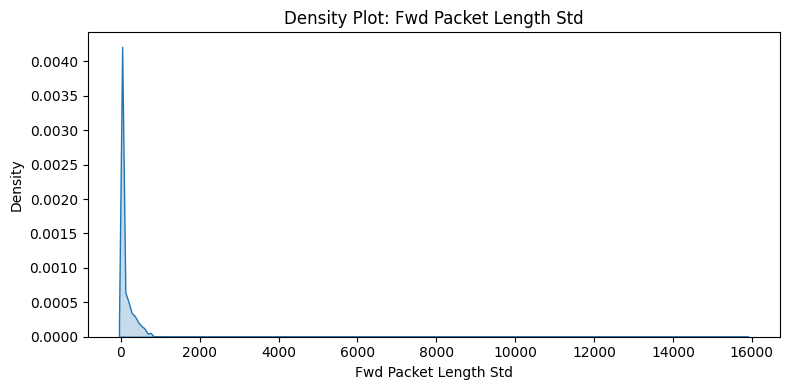

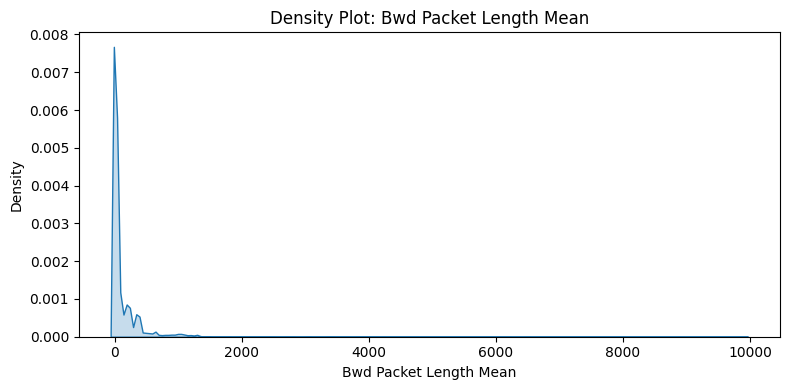

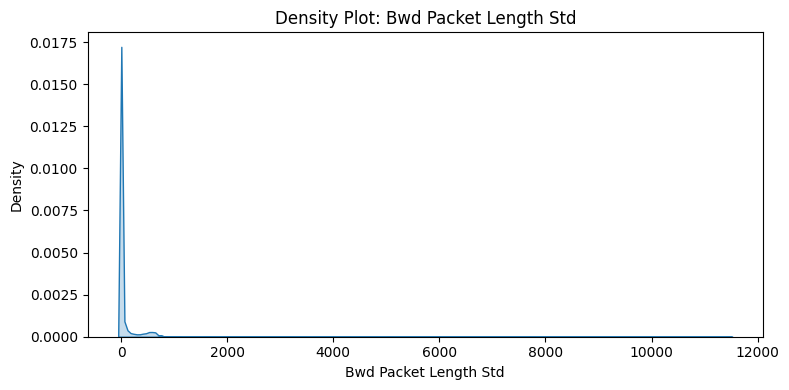

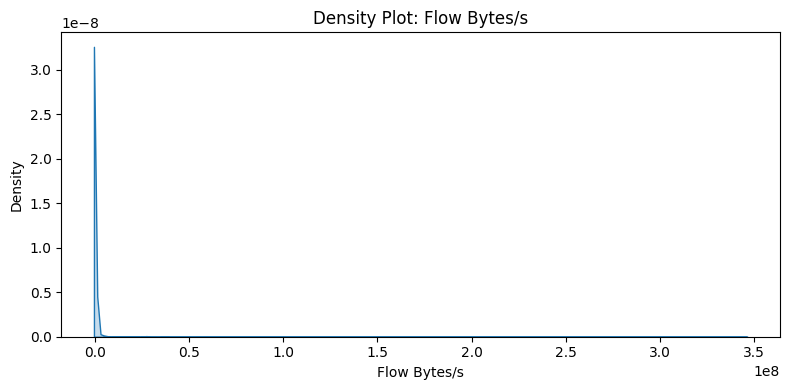

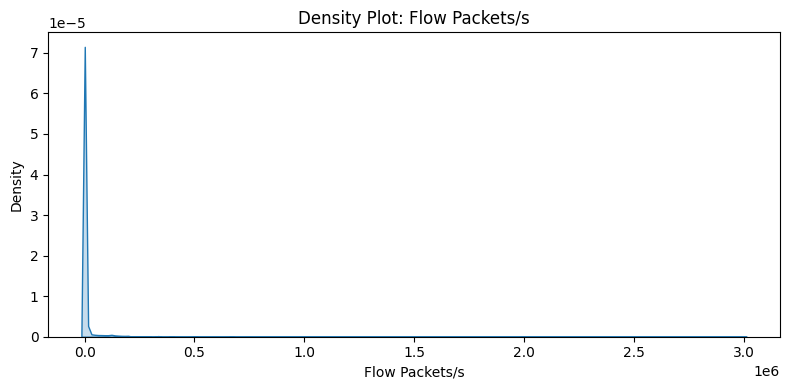

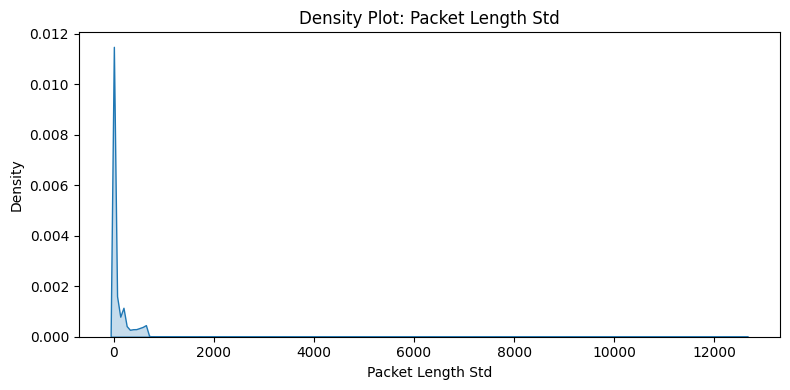

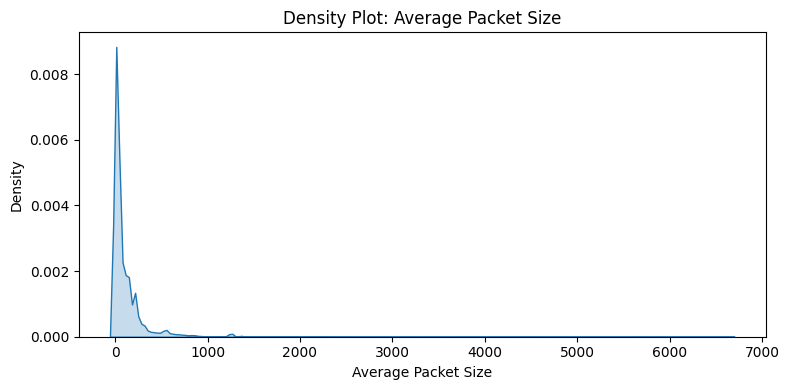

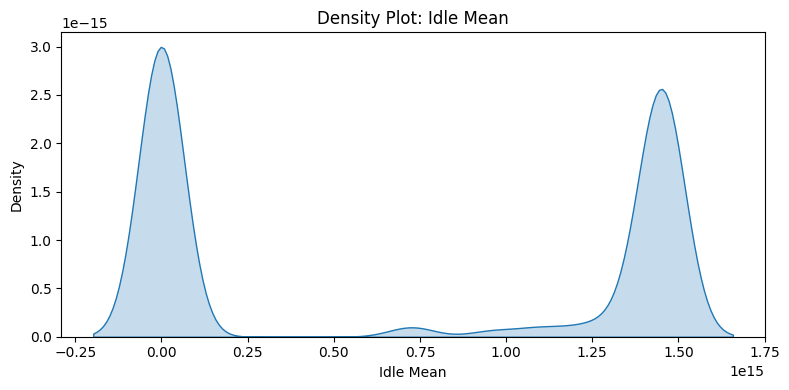

Label Frequencies (%):
- Non-Tor: 65.95%
- NonVPN: 16.87%
- VPN: 16.20%
- Tor: 0.98%
- 5494.505495: 0.00%

Most frequent label: Non-Tor (93309 occurrences, 65.95%)

Variable: Flow Duration
Scale: Ratio
Mode: 16 (527 occurrences, 0.37%)
Median: 416430.5
Mean: 20819965.825695142
Standard Deviation: 38096045.20688477

Variable: Total Fwd Packet
Scale: Ratio
Mode: 1 (40802 occurrences, 28.84%)
Median: 2.0
Mean: 152.8523063004481
Standard Deviation: 2378.725115707975

Variable: Total Bwd packets
Scale: Ratio
Mode: 1 (44488 occurrences, 31.44%)
Median: 1.0
Mean: 154.69426499484032
Standard Deviation: 3419.2939935341997

Variable: Flow Bytes/s
Scale: Ratio
Mode: 0.0 (38043 occurrences, 26.89%)
Median: 74.074138145
Mean: 85114.48474351196
Standard Deviation: 1253100.9814775246

Variable: Flow Packets/s
Scale: Ratio
Mode: 125000.0 (528 occurrences, 0.37%)
Median: 7.2878064259999995
Mean: 10900.175744007498
Standard Deviation: 51407.08693165147

Variable: Fwd Packet Length Mean
Scale: Ratio
Mode

In [132]:
plot_correlation_heatmap(df, selected_columns)
plot_density_per_column(df)
describe_label_distribution(df, label_col='Label')
describe_variables(df, variable_scales)

Count how many duplicate rows there are and delete them

In [133]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
# Remove duplicate rows
remove_duplicate_rows(df)

Number of duplicate rows: 24457


Outlier Detection and Analysis

In [134]:
df = apply_outlier_flagging(df, selected_columns)
output_path = "DarknetWorking_with_outliers.csv"
df.to_csv(output_path, index=False)
analyze_outlier_overlap(df, [f"{col}_Outlier" for col in selected_columns])

Outlier threshold for Flow Duration:
 - Lower bound: -14848417.0
 - Upper bound: 24749815.0
 - Number of outliers in 'Flow Duration': 24269 (20.74%)

Outlier threshold for Total Fwd Packet:
 - Lower bound: -3.5
 - Upper bound: 8.5
 - Number of outliers in 'Total Fwd Packet': 19596 (16.75%)

Outlier threshold for Total Bwd packets:
 - Lower bound: -4.5
 - Upper bound: 7.5
 - Number of outliers in 'Total Bwd packets': 18367 (15.69%)

Outlier threshold for Flow Bytes/s:
 - Lower bound: -2361.696789
 - Upper bound: 3936.1613150000003
 - Number of outliers in 'Flow Bytes/s': 22117 (18.90%)

Outlier threshold for Flow Packets/s:
 - Lower bound: -3482.21784572
 - Upper bound: 5805.939302631999
 - Number of outliers in 'Flow Packets/s': 15769 (13.47%)

Outlier threshold for Fwd Packet Length Mean:
 - Lower bound: -66.0
 - Upper bound: 110.0
 - Number of outliers in 'Fwd Packet Length Mean': 14745 (12.60%)

Outlier threshold for Bwd Packet Length Mean:
 - Lower bound: -229.5
 - Upper bound: 382

In [135]:
rows = []
iqr_any = pd.Series(False, index=df.index)
mad_any = pd.Series(False, index=df.index)
total_n = len(df)

for col in selected_columns:
    # ensure IQR flags exist (<col>_Outlier)
    iqr_col = f"{col}_Outlier"
    if iqr_col not in df.columns:
        Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df[iqr_col] = (df[col] < lb) | (df[col] > ub)
    a = pd.to_numeric(df[iqr_col], errors="coerce").fillna(0).astype(bool)

    # MAD flags (writes <col>_MAD_Outlier)
    b, med, mad_n = _mad_flags(df[col])
    df[f"{col}_MAD_Outlier"] = b

    n_iqr  = int(a.sum())
    n_mad  = int(b.sum())
    both   = int((a & b).sum())
    union  = int((a | b).sum())
    jacc   = (both / union) if union else np.nan

    rows.append({
        "feature": col,
        "IQR_n": n_iqr,
        "IQR_pct": round(n_iqr / total_n * 100, 2),
        "MAD_n": n_mad,
        "MAD_pct": round(n_mad / total_n * 100, 2),
        "Overlap_both": both,
        "Overlap_both_pct": round(both / total_n * 100, 2),
        "Union": union,
        "Union_pct": round(union / total_n * 100, 2),
        "Jaccard": round(jacc, 4) if pd.notna(jacc) else np.nan,
        "Jaccard_pct": round(jacc * 100, 2) if pd.notna(jacc) else np.nan,
    })

    iqr_any |= a
    mad_any |= b

per_feature = pd.DataFrame(rows)

overall_union = int((iqr_any | mad_any).sum())
overall_both  = int((iqr_any & mad_any).sum())
overall_jacc  = (overall_both / overall_union) if overall_union else np.nan

overall = pd.DataFrame([{
    "feature": "__OVERALL__",
    "IQR_n": int(iqr_any.sum()),
    "IQR_pct": round(int(iqr_any.sum()) / total_n * 100, 2),
    "MAD_n": int(mad_any.sum()),
    "MAD_pct": round(int(mad_any.sum()) / total_n * 100, 2),
    "Overlap_both": overall_both,
    "Overlap_both_pct": round(overall_both / total_n * 100, 2),
    "Union": overall_union,
    "Union_pct": round(overall_union / total_n * 100, 2),
    "Jaccard": round(overall_jacc, 4) if pd.notna(overall_jacc) else np.nan,
    "Jaccard_pct": round(overall_jacc * 100, 2) if pd.notna(overall_jacc) else np.nan,
}])

# Show results
display(per_feature.sort_values("Jaccard", na_position="last"))
display(overall)


,feature,IQR_n,IQR_pct,MAD_n,MAD_pct,Overlap_both,Overlap_both_pct,Union,Union_pct,Jaccard,Jaccard_pct
6,Bwd Packet Length Mean,8442,7.21,54588,46.65,8442,7.21,54588,46.65,0.1546,15.46
7,Packet Length Std,14242,12.17,44728,38.22,14242,12.17,44728,38.22,0.3184,31.84
4,Flow Packets/s,15769,13.47,38244,32.68,15769,13.47,38244,32.68,0.4123,41.23
0,Flow Duration,24269,20.74,40072,34.24,24269,20.74,40072,34.24,0.6056,60.56
3,Flow Bytes/s,22117,18.90,35477,30.32,22117,18.90,35477,30.32,0.6234,62.34
5,Fwd Packet Length Mean,14745,12.60,12217,10.44,12217,10.44,14745,12.60,0.8286,82.86
2,Total Bwd packets,18367,15.69,19379,16.56,18367,15.69,19379,16.56,0.9478,94.78
1,Total Fwd Packet,19596,16.75,20585,17.59,19596,16.75,20585,17.59,0.9520,95.20
8,Idle Mean,0,0.00,0,0.00,0,0.00,0,0.00,NaN,NaN


,feature,IQR_n,IQR_pct,MAD_n,MAD_pct,Overlap_both,Overlap_both_pct,Union,Union_pct,Jaccard,Jaccard_pct
0,__OVERALL__,64181,54.84,98737,84.37,64180,54.84,98738,84.37,0.65,65.0


Geometric Median Outliers


--- Geometric Median Outliers at 95th Percentile ---
Total outliers flagged: 5818.0 / 117025


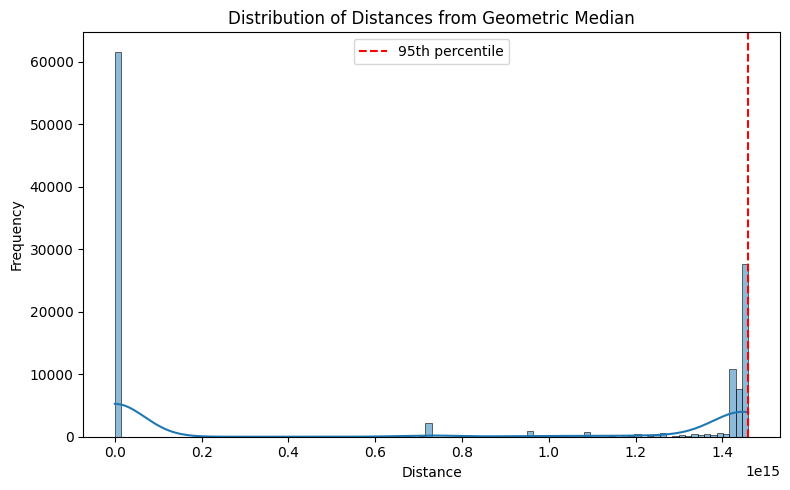

In [136]:
df = geometric_median_outliers(df, selected_columns, threshold_percentile=95)
print(f"\n--- Geometric Median Outliers at 95th Percentile ---")
num_outliers = df['GeoMed_Outlier'].sum()
print(f"Total outliers flagged: {num_outliers} / {len(df)}")

plot_geomed_distance_histogram(df, distance_col='GeoMed_Distance', threshold_percentile=95)

# There's another plot right after PCA analysis to visualize in 2D

PCA analysis

In [137]:
variance_df, loadings_df, pc_scores_df = pca_spss_style(df, selected_columns, n_components=3)
pc_scores_df.index = df.index 


--- Total Variance ---
Component  Eigenvalue  % of Variance  Cumulative %
      PC1        2.61          28.96         28.96
      PC2        1.63          18.15         47.12
      PC3        1.35          14.97         62.09

--- Component Matrix --
                         PC1   PC2   PC3
Flow Duration           0.37 -0.21 -0.15
Total Fwd Packet        0.30  0.59 -0.24
Total Bwd packets       0.27  0.60 -0.25
Flow Bytes/s            0.06  0.23  0.62
Flow Packets/s         -0.13  0.26  0.53
Fwd Packet Length Mean  0.34 -0.00  0.21
Bwd Packet Length Mean  0.39 -0.12  0.20
Packet Length Std       0.52 -0.17  0.27
Idle Mean               0.37 -0.29 -0.16


In order to visualize in 2D

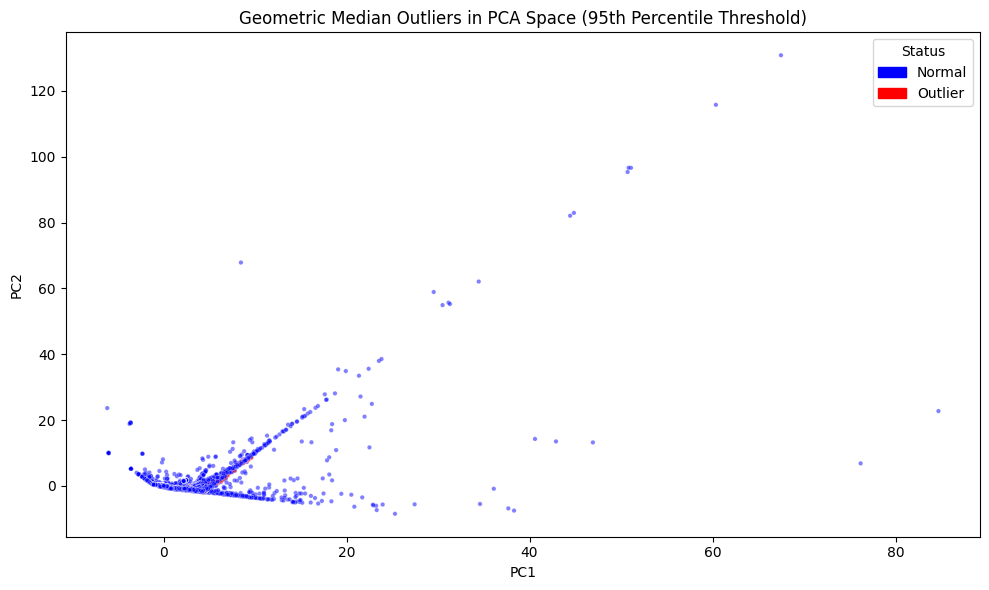

In [138]:
plot_geomed_outliers_pca(pc_scores_df, df, title_suffix="(95th Percentile Threshold)")

Clustering Analysis

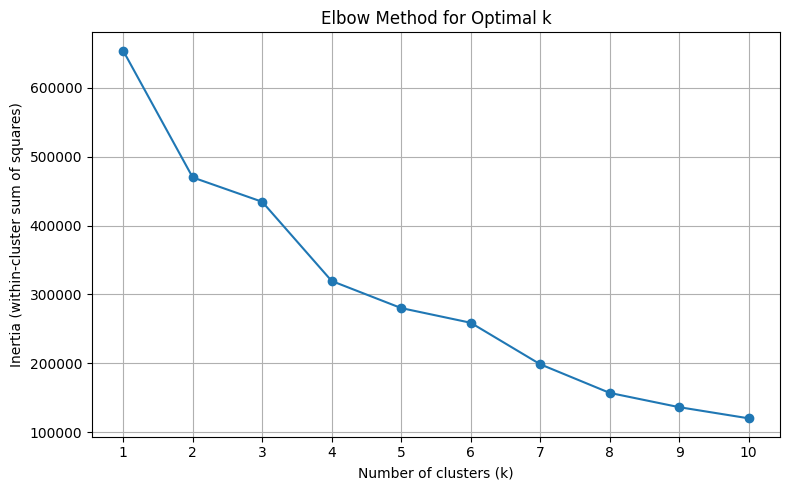

C:\Users\user1\AppData\Local\Temp\ipykernel_35504\862041733.py:245: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = combined_df.groupby("Cluster", group_keys=False).apply(


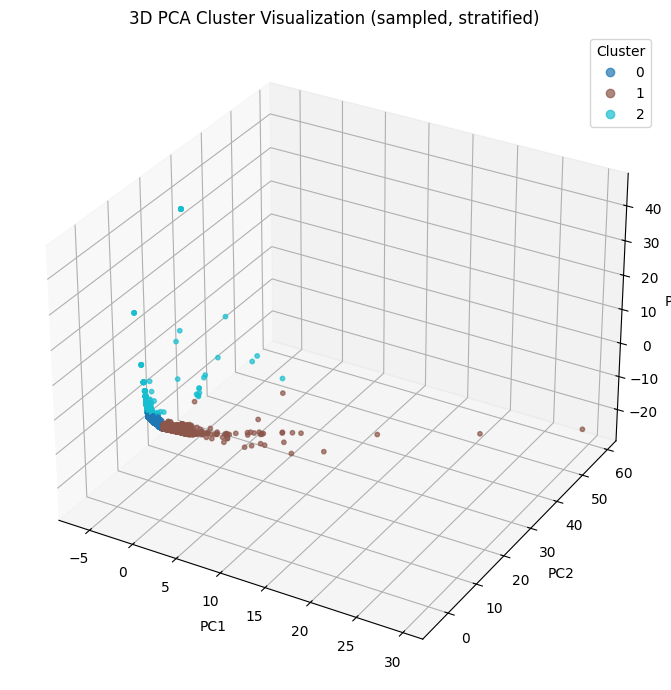

In [139]:
plot_elbow_method(pc_scores_df, max_k=10)
labels, kmeans_model = run_kmeans_clustering(pc_scores_df, n_clusters=3)
df['Cluster'] = labels
df.to_csv("DarknetWorking_with_outliers.csv", index=False)
plot_3d_clusters_sampled(pc_scores_df, df['Cluster'], sample_size=5000)

Detect anomalies using Isolation Forest 

Detected 2341.0 anomalies out of 117025 rows.


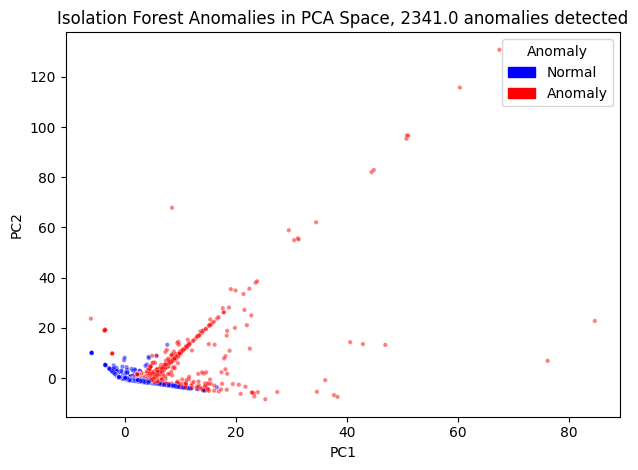

C:\Users\user1\AppData\Local\Temp\ipykernel_35504\862041733.py:489: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')


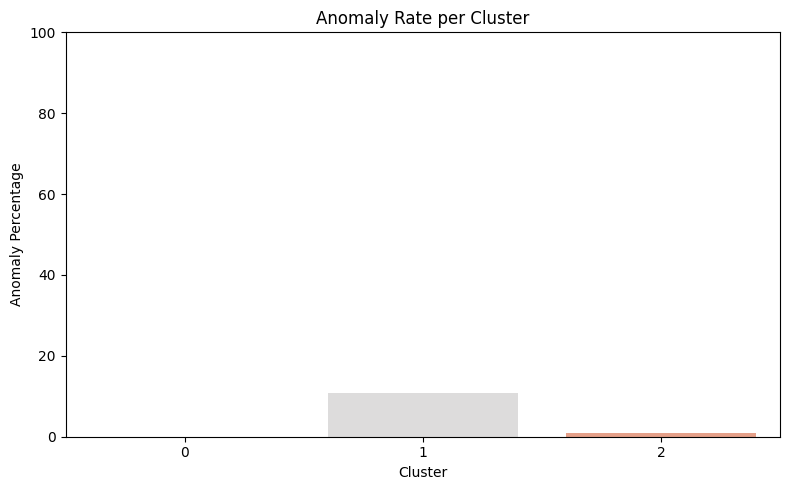

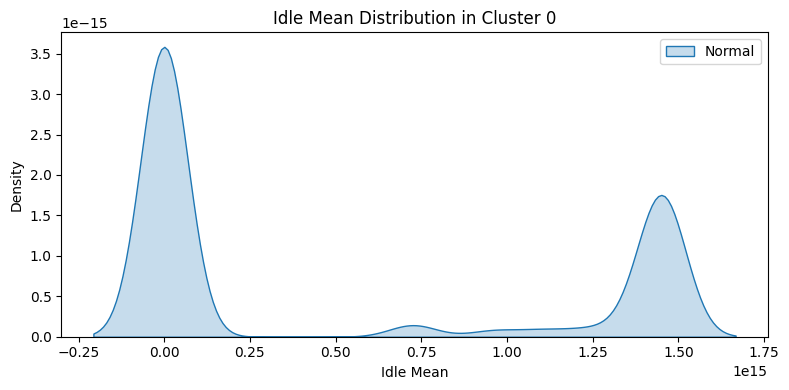

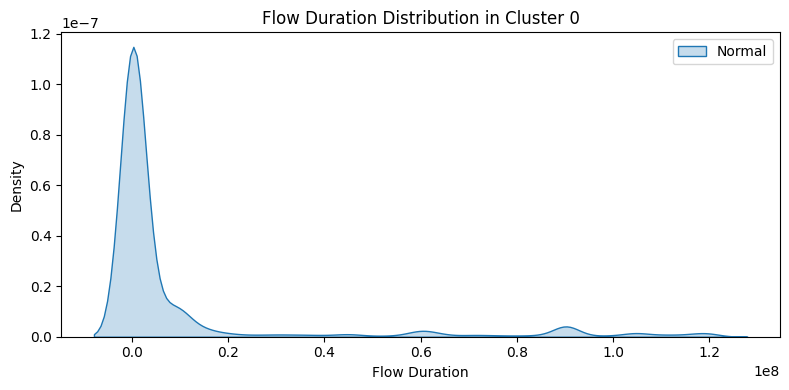

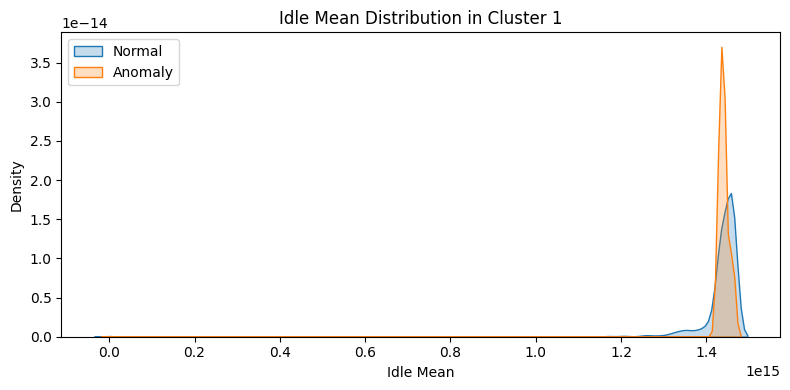

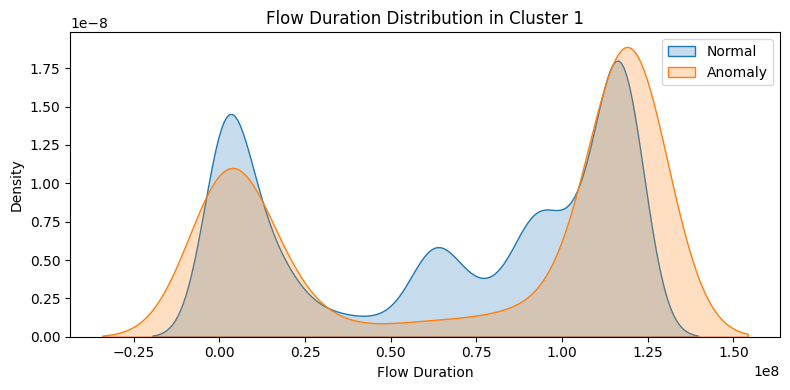

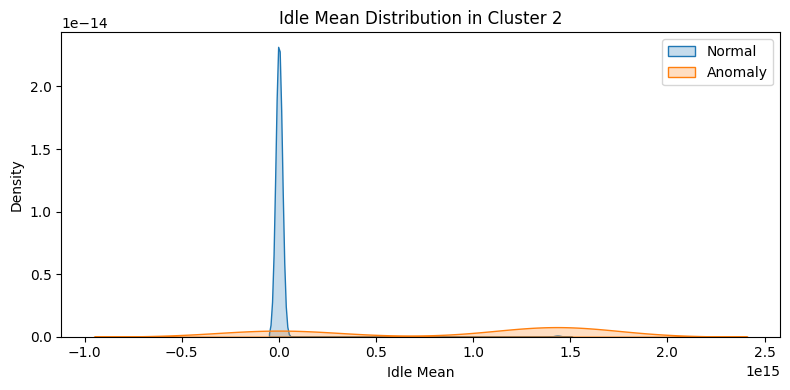

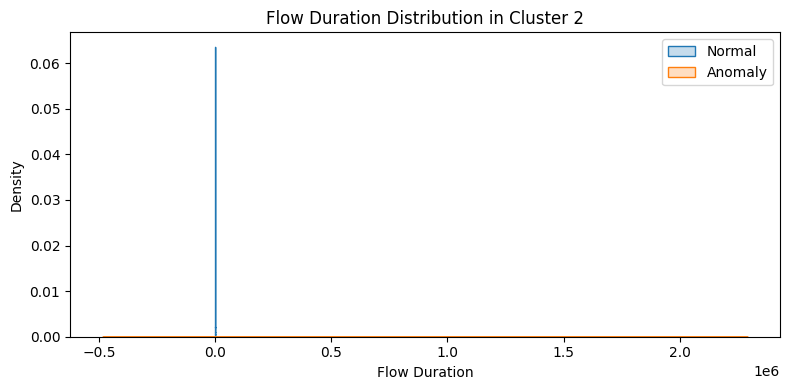

In [140]:
df = detect_anomalies_isolation_forest(df, selected_columns, contamination=0.02)
number_of_anomalies = df['AnomalyIF'].sum()
print(f"Detected {number_of_anomalies} anomalies out of {len(df)} rows.")
# 2D PCA Scatterplot with anomaly overlay
sns.scatterplot(
    x=pc_scores_df['PC1'],
    y=pc_scores_df['PC2'],
    hue=df['AnomalyIF'].map({0: "Normal", 1: "Anomaly"}),
    palette={"Normal": "blue", "Anomaly": "red"},
    alpha=0.5,
    s=10
)
# Create custom legend handles
legend_handles = [
    mpatches.Patch(color='blue', label='Normal'),
    mpatches.Patch(color='red', label='Anomaly')
]
# Set title and labels
plt.title(f"Isolation Forest Anomalies in PCA Space, {number_of_anomalies} anomalies detected")
plt.xlabel("PC1")
plt.ylabel("PC2")
# Apply custom legend
plt.legend(handles=legend_handles, title='Anomaly')
plt.tight_layout()
plt.show()

# Summarize anomalies by cluster and plot
summary_df = summarize_anomalies_by_cluster(df, 'Cluster','AnomalyIF')
plot_anomaly_rates(summary_df)
key_features = ['Idle Mean', 'Flow Duration']
compare_anomaly_distributions(df, key_features,'Cluster','AnomalyIF')

(OC-SVM) Detected 2600 anomalies out of 117025 rows.


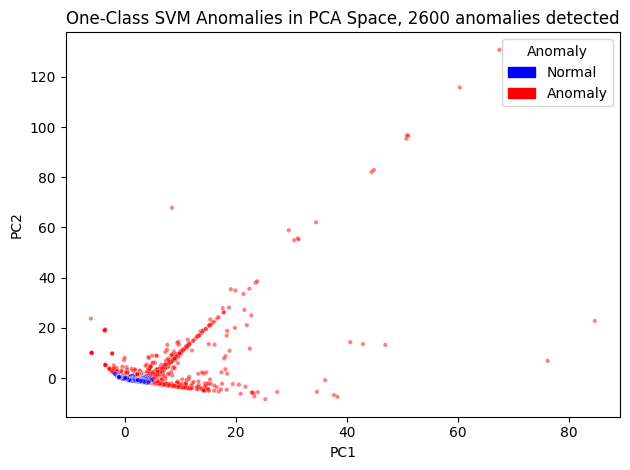

C:\Users\user1\AppData\Local\Temp\ipykernel_35504\862041733.py:489: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')


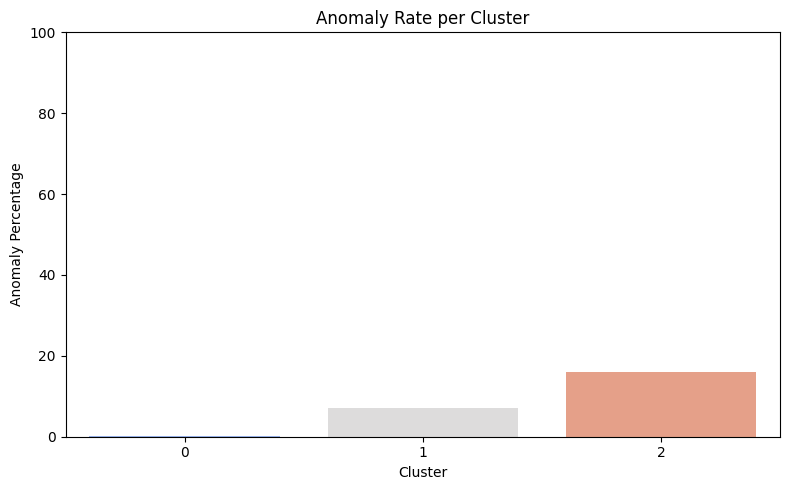

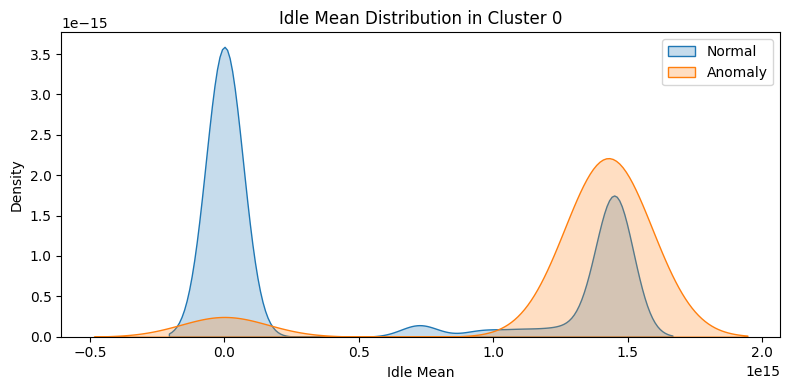

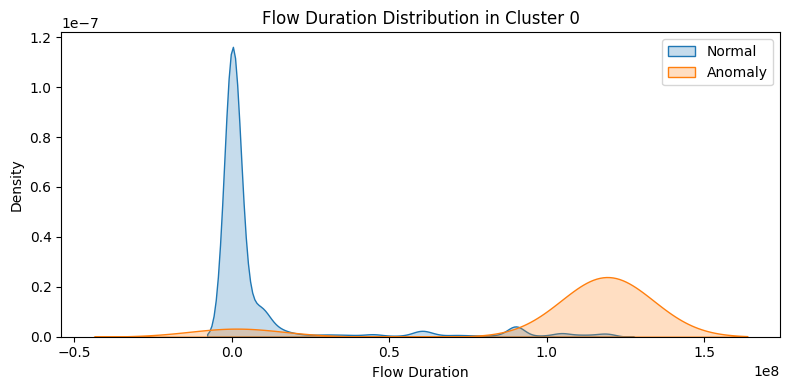

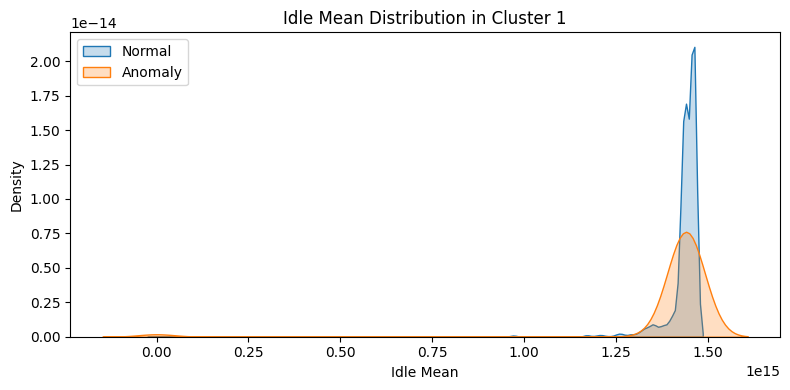

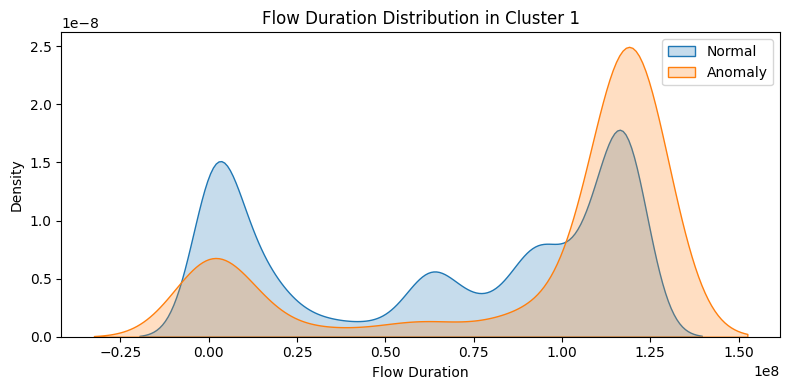

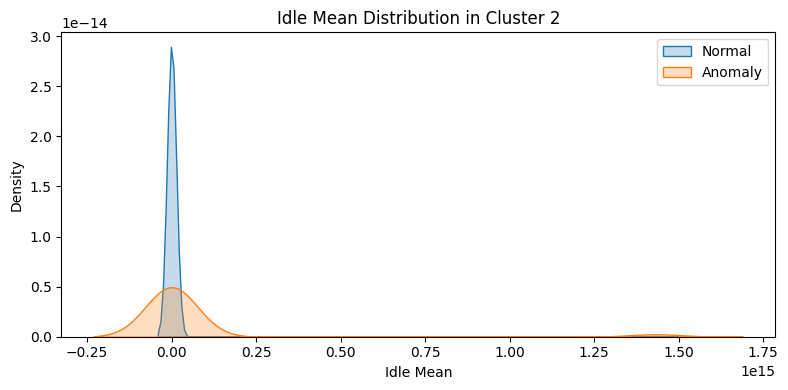

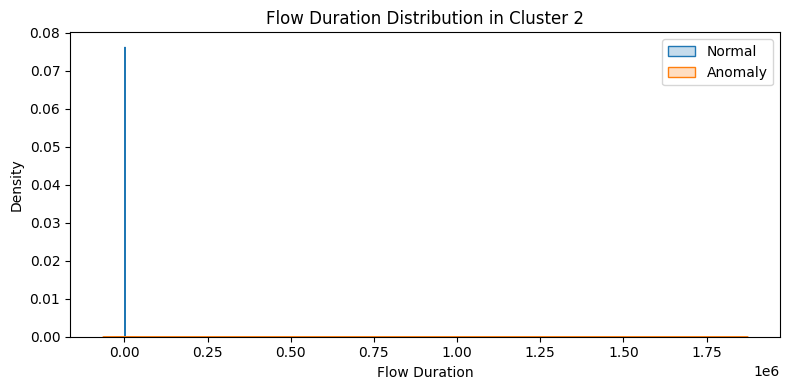

In [141]:

df = detect_anomalies_oneclass_svm_on_pcs(df, pc_scores_df, nu=0.02)

number_of_anomalies_oc = int(df["Anomaly_OCSVM"].fillna(0).sum())
print(f"(OC-SVM) Detected {number_of_anomalies_oc} anomalies out of {len(df)} rows.")

# ---- PCA scatter with OC-SVM overlay (robust hue selection) ----
hue_series = df["Anomaly_OCSVM"].reindex(pc_scores_df.index).fillna(0).map({0: "Normal", 1: "Anomaly"})

sns.scatterplot(
    x=pc_scores_df["PC1"],
    y=pc_scores_df["PC2"],
    hue=hue_series,
    palette={"Normal": "blue", "Anomaly": "red"},
    alpha=0.5, s=10
)
legend_handles = [
    mpatches.Patch(color="blue", label="Normal"),
    mpatches.Patch(color="red", label="Anomaly")
]
plt.title(f"One-Class SVM Anomalies in PCA Space, {number_of_anomalies_oc} anomalies detected")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(handles=legend_handles, title="Anomaly")
plt.tight_layout()
plt.show()

# ---- Reuse your summaries/plots with the new flags ----
tmp = df.copy()
tmp["Anomaly"] = tmp["Anomaly_OCSVM"].fillna(0).astype(int)
summary_df_oc = summarize_anomalies_by_cluster(tmp)
plot_anomaly_rates(summary_df_oc)

key_features = ["Idle Mean", "Flow Duration"]
compare_anomaly_distributions(tmp, key_features)

In [142]:

def _to_bool_series(df, col):
    if col not in df.columns: 
        return pd.Series(False, index=df.index)
    s = pd.to_numeric(df[col], errors="coerce")
    return s.fillna(0).astype(int).astype(bool)

a = _to_bool_series(df, "AnomalyIF")        # IF flags
b = _to_bool_series(df, "Anomaly_OCSVM")     # OC-SVM flags

N       = len(df)
n_if    = int(a.sum())
n_oc    = int(b.sum())
both    = int((a & b).sum())
if_only = int((a & ~b).sum())
oc_only = int((~a & b).sum())
agree   = int((a & b).sum() + (~a & ~b).sum())
union   = int((a | b).sum())
jaccard = (both / union) if union else np.nan
agree_rate = (agree / N) if N else np.nan

summary = pd.DataFrame([{
    "N": N,
    "IF_outliers": n_if,
    "OCSVM_outliers": n_oc,
    "Both": both,
    "IF_only": if_only,
    "OCSVM_only": oc_only,
    "Agreement_rate": round(agree_rate, 4),
    "Jaccard_index": round(jaccard, 4),
}])

print("=== Summary ==="); display(summary)

# Optional: 2x2 table and per-cluster rates
contingency = pd.crosstab(a.rename("IF"), b.rename("OCSVM"))
print("\n=== 2x2 Contingency ==="); display(contingency)

if "Cluster" in df.columns:
    cluster_rates = (
        df.assign(IF=a.astype(int), OC=b.astype(int))
          .groupby("Cluster")[["IF","OC"]].mean().mul(100)
          .rename(columns={"IF":"IF_%","OC":"OC_%"})
          .reset_index()
    )
    print("\n=== Cluster anomaly rates (% of cluster) ==="); display(cluster_rates)


=== Summary ===


,N,IF_outliers,OCSVM_outliers,Both,IF_only,OCSVM_only,Agreement_rate,Jaccard_index
0,117025,2341,2600,1152,1189,1448,0.9775,0.304



=== 2x2 Contingency ===


OCSVM,False,True
IF,,
False,113236,1448
True,1189,1152



=== Cluster anomaly rates (% of cluster) ===


,Cluster,IF_%,OC_%
0,0,0.000000,0.145818
1,1,10.837322,7.084301
2,2,0.887574,16.009204


Cluster Interpretation

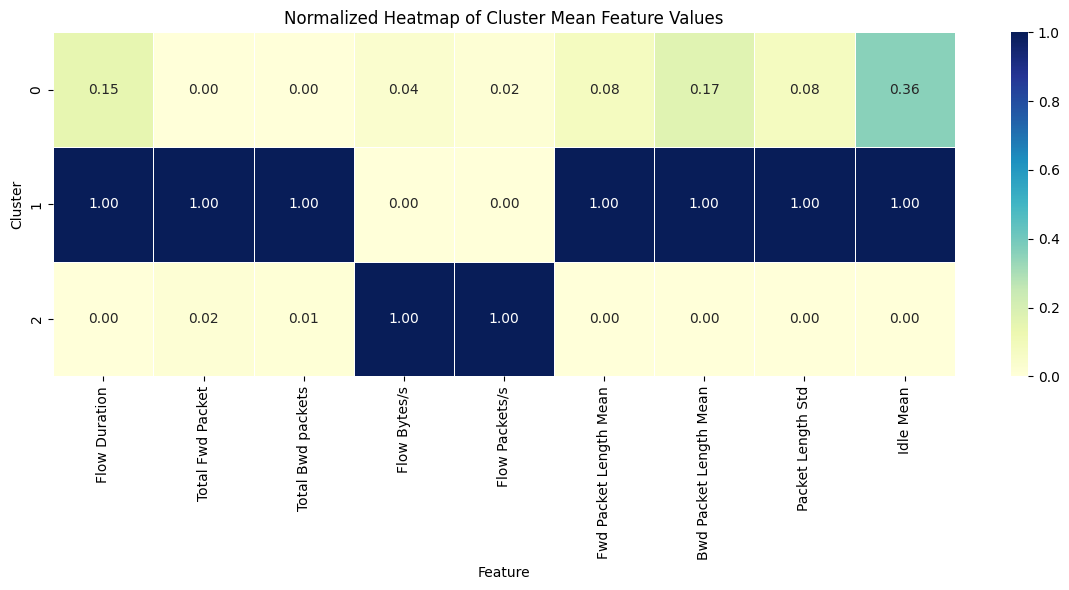

In [143]:
summary_df = interpret_clusters(df, selected_columns)
summary_df.to_csv("cluster_summary.csv", index=True)
plot_normalized_cluster_mean_heatmap(df, selected_columns, cluster_col='Cluster')

Temporal feature engineering

In [144]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['Timestamp'])  # remove rows with bad timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.day_name()
df['WeekGroup'] = df['DayOfWeek'].apply(lambda x: 'DuringWeek' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday'] else 'Weekend')
df['PartOfDay'] = pd.cut(
    df['Hour'],
    bins=[6, 12, 18, 24],
    labels=['Morning', 'Afternoon', 'Evening'],
    right=False
)

Temporal Analysis

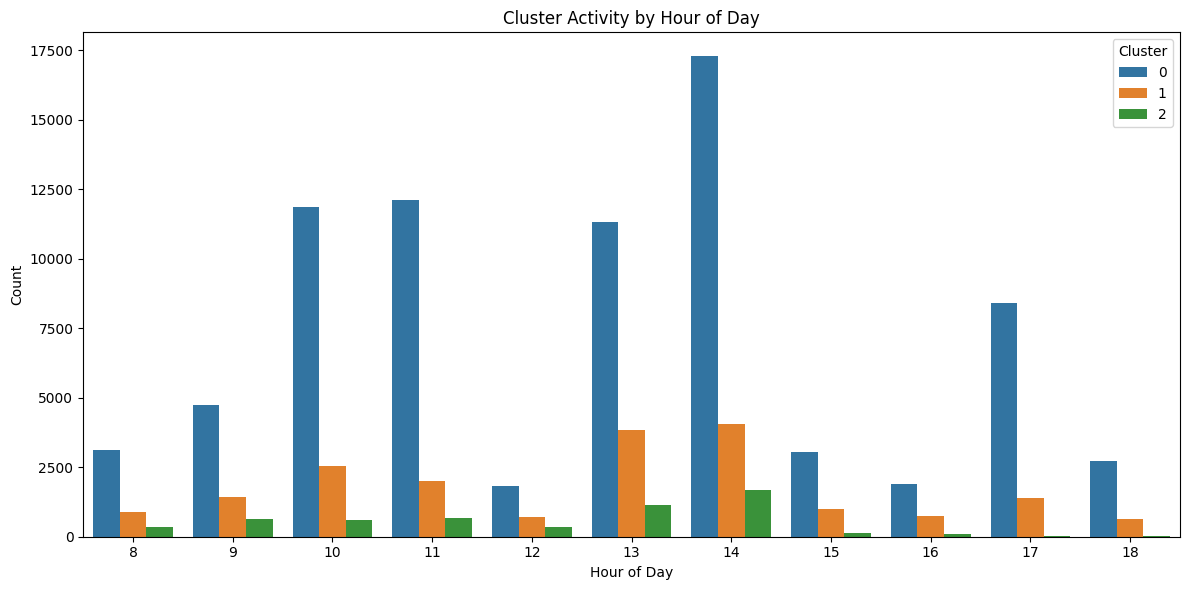

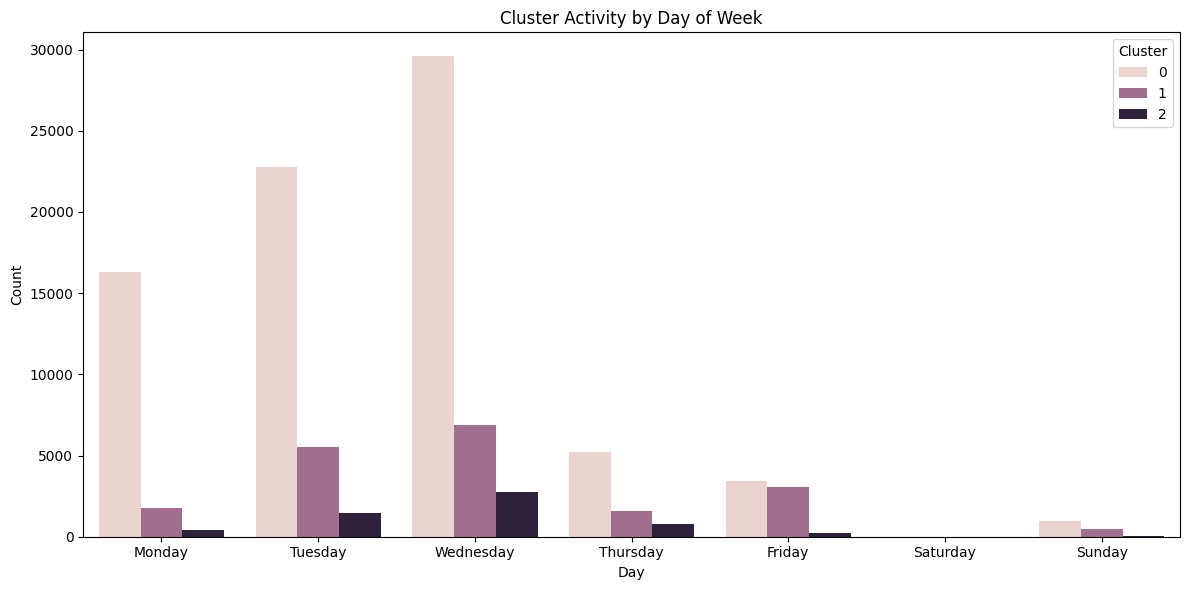

In [145]:
temporal_analysis("DarknetWorking_with_outliers.csv", timestamp_col="Timestamp", cluster_col="Cluster")

temporal_ks = run_temporal_ks_tests(df, selected_columns, time_col='PartOfDay', cluster_col='Cluster')
temporal_ks.to_csv("temporal_ks_results.csv", index=False)

temporal_ks = run_temporal_ks_tests(df, selected_columns, time_col='WeekGroup', cluster_col='Cluster')
temporal_ks.to_csv("temporal_ks_resultsday.csv", index=False)

Visualize Temporal Differences

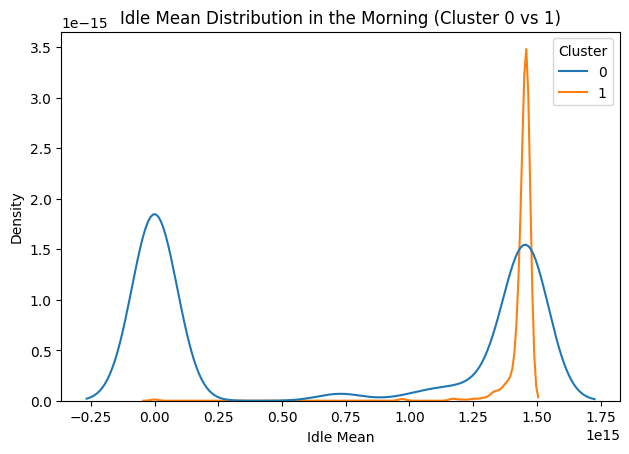

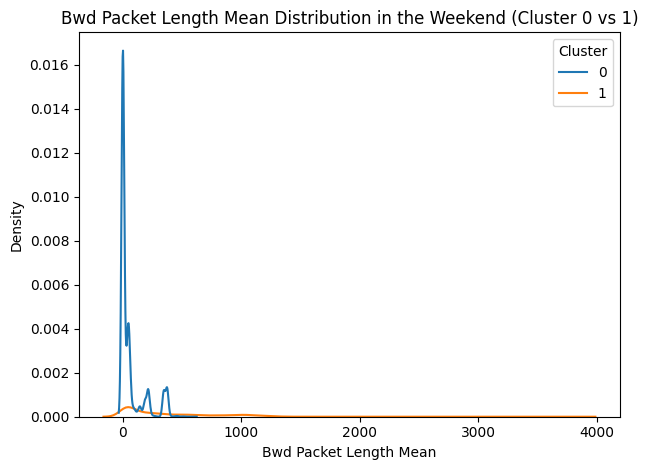

In [146]:
sns.kdeplot(data=df[df['Cluster'].isin([0,1]) & (df['PartOfDay'] == 'Morning')], x='Idle Mean', hue='Cluster')
plt.title("Idle Mean Distribution in the Morning (Cluster 0 vs 1)")
plt.xlabel("Idle Mean")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


sns.kdeplot(data=df[df['Cluster'].isin([0,1]) & (df['WeekGroup'] == 'DuringWeek')], x='Bwd Packet Length Mean', hue='Cluster')
plt.title("Bwd Packet Length Mean Distribution in the Weekend (Cluster 0 vs 1)")
plt.xlabel("Bwd Packet Length Mean")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

Information Flow Graph 

Showing only 100.


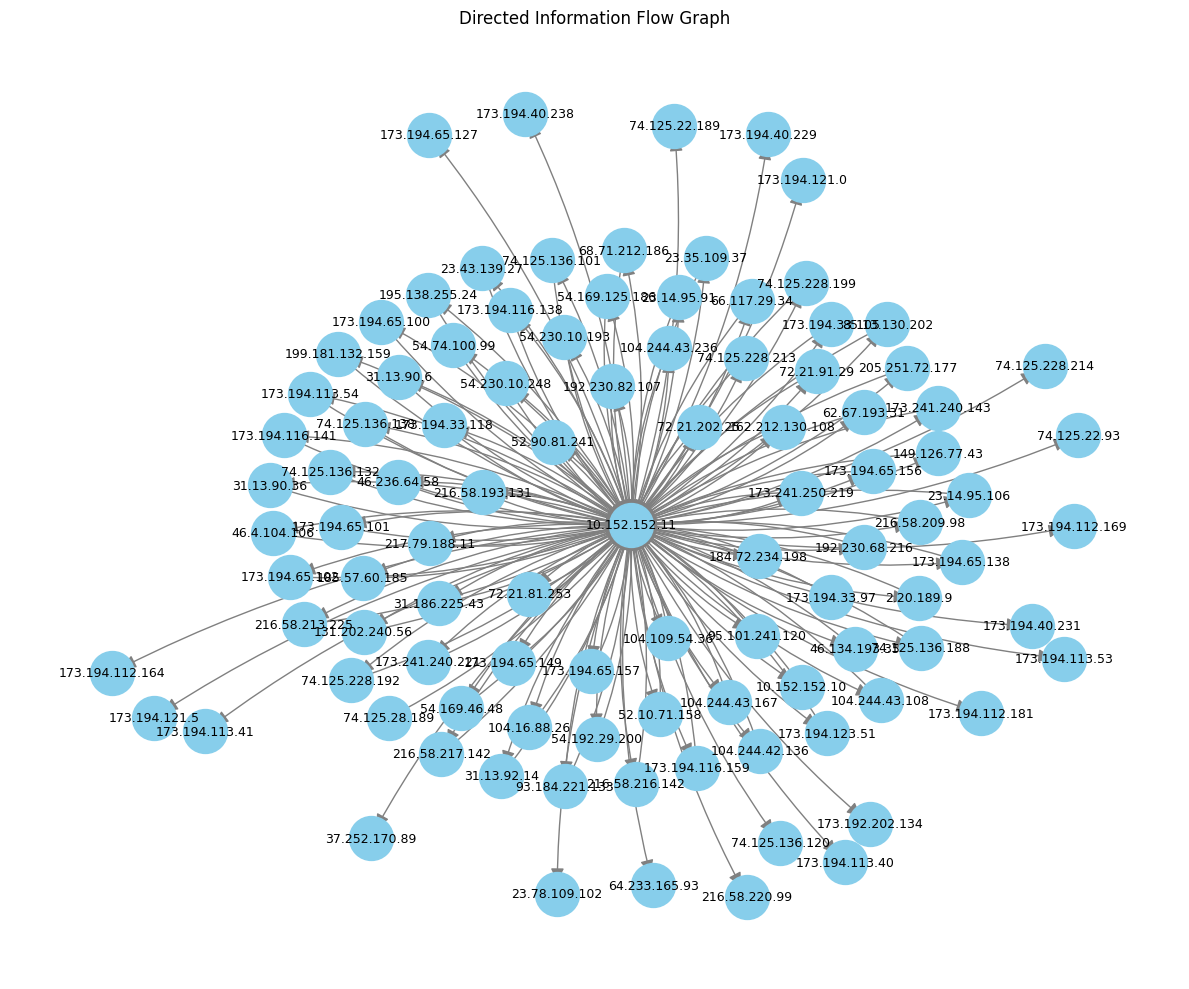

In [147]:
G = build_info_flow_graph(df)
plot_info_flow_graph(G)